## This model expands the simple spherical and symmetric wind model with a constant wind velocity, along with a 'pseudo signal' revolving within it by indroducing an elliptical orbit, 3D coordinate system, accelerating wind and eclipses.
## The main goal of this model is to quantify the amount of electrons along a line of sight from the orbit given an orbital phase, inclination and eccentricity.
## Stellar parameters are modelled after the star SS 2883 of the HMXB system PSR B1259-63. Wind terminal velocity is taken from the paper - https://arxiv.org/pdf/0806.4868, while the remaining stellar properties are taken from https://ui.adsabs.harvard.edu/abs/2011ApJ...732L..11N/abstract, https://arxiv.org/abs/1307.7083 and https://arxiv.org/pdf/1804.08402.

# Equations and Geometry
## Electron number density
# $n_{e}(r) = \frac{\rho}{\mu_{e}m_{p}} = \frac{\dot{M}}{4\pi\mu_{e}m_{p}r^2v(r)} = \frac{k}{r^2v(r)}$
Where
# $\rho = \frac{\dot{M}}{4\pi r^2v(r)}$

And

# $k = \frac{\dot{M}}{4\pi\mu_{e}m_{p}}$
With

* $\rho$ =      Density
* $\mu_{e}$ =   Mean molecular weight per free electron (typically set at a value of 1.2)
* $m_{p}$ =     Proton mass
* $\dot{M}$ =   Wind mass loss
* $v(r)$ =     Radial wind velocity
* $r$ =         radial distance from the center of the star

## Accelerating Wind ($\beta$ law)
The wind velocity at a certain distance away from the star is 
# $v(r) = v_0 + (v_{\infty} - v_0)(1-\frac{R_{*}}{r})^\beta$
with 
* $v_0$ =        The wind velocity at stellar surface
* $v_{\infty}$ = Wind terminal velocity
* $R_{*}$ =      Stellar radius
* $\beta$ =      Wind acceleration exponent

By placing the star and orbit at the xy plane origin, we can consider an elliptical orbit in cartesian coordinates
# $\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1$
with
* $a$ = Semi-major axis
* $b$ = Semi-minor axis
The semi-minor axis can be defined as $a\sqrt{1 - e^2}$, where $e^2$ is the eccentricity.
In polar coordinates, since the ellipse is offset by along the x-axis by the focus - $f = ae$, the coordinates relative to the star are
## $x = rcos(\phi) - ae$, $y = bsin(\phi)$, and $r = \sqrt{x^2 + y^2}$
The orbital separation in polar coordinates becomes
# $r = \frac{a(1-e^2)}{1+ecos(\phi)}$
Where $\phi$ is the true anomaly.
The signal position in polar coordinates is defined as $r_s = r(cos(\phi + \omega),sin(\phi + \omega),0)$, where $\omega$ is the argument of periastron. The observer unit vector (direction of signal to observer) is then defined as $\hat{n} = (sin(i)cos(\Omega), sin(i)sin(\Omega), cos(i))$, where $i$ is the inclination and $\Omega$ is the longitude of ascending node. The radial distance of the signal from the star along the path of the line of sight becomes $r(s) = r_s + s\hat{n}$, where $s\ge0$, is the distance along the line of sight. 

The number density at a specific point along the line of sight distance from the orbit can then be described as
# $n_e(r(s)) = \frac{k}{r(s)^2v(r(s))}$

From the definition of $r(s)$, 

## $r(s)^2 = (r_s + s\hat{n})^2 = r^2 + 2rs [cos(\phi + \omega) sin (i)cos(\Omega) + sin(\phi + \omega)sin(i)sin(\Omega)] + s^2$

## Dispersion Measure
# $DM(\phi,i) = \int_{0}^{\infty}n_e(r(s))ds = k\int_{0}^{\infty}\frac{ds}{v(r(s))r(s)^2}$

## Semi-major axis of PSR B1259-63
Given that the orbital period of PSR B1259-63 is approximately 1237 days, its mass is $1.4 M_\odot$ and that the mass of SS 2883 is approximately $20 M_\odot$, using Kepler's 3rd law, the semi-major axis is
# $a^3 = \frac{P^2G(M + m)}{4\pi^2}, a \sim 1345R_\odot$
With
* $P$ = Orbital period
* G = Gravitational constant
* M = Mass of SS 2883
* m = Mass of PSR B1259-63

## Free-free Absorption
Free-free absorption causes signals to be absorbed by the stellar wind depending on its optical depth.
# $\tau_{FFA} \approx 8.24x10^{-2}\nu^{-2.1}T_e^{-1.35}\int n_e^2ds$

with
* $\tau_{FFA}$ = The optical depth
* $\nu$ = The signal frequency 
* $T_e$ = The stellar wind temperature
* $n_e$ = The number density
* $s$ = The line of sight distance

In [1]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import astropy.units as u
import astropy.constants as con
import ipywidgets as widgets
from IPython.display import display

In [2]:
#Number density function
def num_density(phi, i, a_Rsun, R_star_sol, Mdot_Msun_per_yr, v_0_kms, v_inf_kms, s, e, omega, Omega, beta, mu_e=1.2):
    '''This function calculates the number density at a specific point along an elliptical orbit within a spherically cymmetric wind 
    with accelerating velocity.
    -----------------------------------------------------------------------------------------------------------------------------
    parameters:
    
    phi              [float] -> True anomaly (rad)
    i                [float] -> Inclination (rad)
    a_Rsun           [float] -> Orbital radius (solar radii)
    R_star_sol       [float] -> Stellar radius (solar radii)
    Mdot_Msun_per_yr [float] -> Wind mass loss (solar masses per year)
    v_0_kms          [float] -> Wind velocity at stellar radius (km/s)
    v_inf_kms        [float] -> Terminal velocity of wind (km/s)
    mu_e             [float] -> Mean molecular weight per free electron
    e                [float] -> Eccentricity (0 < e < 1)
    s                [float] -> Distance along line of sight from signal (AU)
    omega            [float] -> Argument of periastron (rad)
    Omega            [float] -> Longitude of ascending node (rad)
    beta             [float] -> Wind acceleration exponent 
    
    -----------------------------------------------------------------------------------------------------------------------------
    Returns:
    
    The function returns the number density [array] -> (cm^-3)'''
    a = (a_Rsun * con.R_sun).cgs.value                                                                                   #Converts the semi-mmajor axis from solar radii to cm
    R_star = (R_star_sol * con.R_sun).cgs.value                                                                          #Converts the stellar radius from solar radii to cm
    Mdot = (Mdot_Msun_per_yr * con.M_sun / (1 * u.yr)).cgs.value                                                         #Converts the stellar mass loss from solar mass per year to g/s
    v_0 = (v_0_kms * u.km / u.s).cgs.value                                                                               #Converts the stellar surface wind velocity ftom km/s to cm/s
    v_inf = (v_inf_kms * u.km / u.s).cgs.value                                                                           #Converts the terminal wind velocity from km/s to cm/s
    k = Mdot / (4*np.pi*mu_e*con.m_p.cgs.value)                                                                          #Calculates the k constant (cm^-1)
    r = a*(1 - e**2)/(1 + e*np.cos(phi))                                                                                 #Calculates the orbital separation along the orbit
    r_s_sqrd = r**2 + 2*r*s*(np.cos(phi+omega)*np.sin(i)*np.cos(Omega)+np.sin(phi+omega)*np.sin(i)*np.sin(Omega)) + s**2 #Calculates the squared radial distance from the star along the line of sight
    v_r_s = v_0 + (v_inf-v_0)*(1-R_star/np.sqrt(r_s_sqrd))**beta                                                         #Calculates the velocity of the wind 

    n_e = k/(r_s_sqrd*v_r_s)                                                                                             #Calculates the number density
    n_e[np.sqrt(r_s_sqrd) <= R_star] = 0                                                                                 #Eclipse condition
     
    return n_e

In [3]:
#DM function
def dm_beta_wind(phi, i, a_Rsun, R_star_sol, Mdot_Msun_per_yr, v_0_kms, v_inf_kms, e, omega, Omega, beta, mu_e=1.2, s_array_cm=None):
    '''This function calculates the dispersion measure along a line of sight, given orbital phase and inclination, 
    assuming a spherically symmetric wind with an accelerating velocity.
    --------------------------------------------------------------------------------------------------------------
    Parameters:
    
    phi              [float] -> True anomaly (rad)
    i                [float] -> Inclination (rad)
    a_Rsun           [float] -> Orbital radius (solar radii)
    R_star_sol       [float] -> Stellar radius (solar radii)
    Mdot_Msun_per_yr [float] -> Wind mass loss (solar masses per year)
    v_0_kms          [float] -> Wind velocity at stellar radius (km/s)
    v_inf_kms        [float] -> Terminal velocity of wind (km/s)
    e                [float] -> Eccentricity (0 < e < 1)
    omega            [float] -> Argument of periastron (rad)
    Omega            [float] -> Longitude of ascending node (rad)
    beta             [float] -> Wind acceleration exponent 
    mu_e             [float] -> Mean molecular weight per free electron
    
    --------------------------------------------------------------------------------------------------------------
    Returns:
    
    The function returns the dispersion measure [array] -> (pc cm^-3).'''
    a = (a_Rsun * con.R_sun).cgs.value                           #Converts the semi-major axis from solar radii to cm
    R_star = (R_star_sol * con.R_sun).cgs.value                  #Converts the stellar radius from solar radii to cm
    Mdot = (Mdot_Msun_per_yr * con.M_sun / (1 * u.yr)).cgs.value #Converts the stellar mass loss from solar mass per year to g/s
    v_0 = (v_0_kms * u.km / u.s).cgs.value                       #Converts the stellar surface wind velocity ftom km/s to cm/s
    v_inf = (v_inf_kms * u.km / u.s).cgs.value                   #Converts the wind velocity from km/s to cm/s
    k = Mdot / (4*np.pi*mu_e*con.m_p.cgs.value)                  #Calculates the k constant (cm^-1)

    #Instantiating a line of sight array
    if s_array_cm is None:
        s_array_cm = np.logspace(np.log10(1e12), np.log10((20000 * con.au).value), 512)  
    s = np.asarray(s_array_cm, dtype=float)

    #Initialising a DM array
    DM_array = []

    for value in phi:
        r = a * (1 - e**2) / (1 + e * np.cos(value))                                 #Calculates the orbital separation along the orbit
        r_s_sqrd = r**2 + 2*r*s*(np.cos(value+omega)*np.sin(i)*np.cos(Omega) +       #Calculates the squared radial distance from the star along the line of sight
                                 np.sin(value+omega)*np.sin(i)*np.sin(Omega)) + s**2
        v_r_s = v_0 + (v_inf - v_0) * (1 - R_star/np.sqrt(r_s_sqrd))**beta           #Calculates the velocity of the wind 
        n_e = k / (r_s_sqrd * v_r_s)                                                 #Calculates the number density
        n_e[np.sqrt(r_s_sqrd) <= R_star] = 0                                         #Eclipse condition

        DM_cgs = np.trapz(n_e, s)                                                    #Integrating the DM in cm^-2
        DM = (DM_cgs / u.pc.to(u.cm))                                                #Converting DM to pc cm^3
        DM_array.append(DM)

    return np.array(DM_array) 

In [4]:
#Free-free absorption function
def ffa(phi, i, a_Rsun, R_star_sol, Mdot_Msun_per_yr, v_0_kms, v_inf_kms, e, omega, Omega, beta, nu, T, mu_e=1.2, s_array_cm=None):
    '''This function calculates the free-free absorption along a line of sight, given orbital phase and inclination, 
    assuming a spherically symmetric wind with an accelerating velocity.
    --------------------------------------------------------------------------------------------------------------
    Parameters:
    
    phi              [float] -> True anomaly (rad)
    i                [float] -> Inclination (rad)
    a_Rsun           [float] -> Orbital radius (solar radii)
    R_star_sol       [float] -> Stellar radius (solar radii)
    Mdot_Msun_per_yr [float] -> Wind mass loss (solar masses per year)
    v_0_kms          [float] -> Wind velocity at stellar radius (km/s)
    v_inf_kms        [float] -> Terminal velocity of wind (km/s)
    e                [float] -> Eccentricity (0 < e < 1)
    omega            [float] -> Argument of periastron (rad)
    Omega            [float] -> Longitude of ascending node (rad)
    beta             [float] -> Wind acceleration exponent
    nu               [float] -> Signal frequency (GHz)
    T                [float] -> Stellar wind temperature (K)
    mu_e             [float] -> Mean molecular weight per free electron
    
    --------------------------------------------------------------------------------------------------------------
    Returns:
    
    The function returns the optical depth [array].'''
    a = (a_Rsun * con.R_sun).cgs.value                           #Converts the semi-major axis from solar radii to cm
    R_star = (R_star_sol * con.R_sun).cgs.value                  #Converts the stellar radius from solar radii to cm
    Mdot = (Mdot_Msun_per_yr * con.M_sun / (1 * u.yr)).cgs.value #Converts the stellar mass loss from solar mass per year to g/s
    v_0 = (v_0_kms * u.km / u.s).cgs.value                       #Converts the stellar surface wind velocity ftom km/s to cm/s
    v_inf = (v_inf_kms * u.km / u.s).cgs.value                   #Converts the wind velocity from km/s to cm/s
    k = Mdot / (4*np.pi*mu_e*con.m_p.cgs.value)                  #Calculates the k constant (cm^-1)

    #Instantiating a line of sight array
    if s_array_cm is None:
        s_array_cm = np.logspace(np.log10(1e12), np.log10((20000 * con.au).value), 512)  
    s = np.asarray(s_array_cm, dtype=float)

    #Initialising an optical depth array
    tau_array = []

    for value in phi:
        r = a * (1 - e**2) / (1 + e * np.cos(value))                                 #Calculates the orbital separation along the orbit
        r_s_sqrd = r**2 + 2*r*s*(np.cos(value+omega)*np.sin(i)*np.cos(Omega) +       #Calculates the squared radial distance from the star along the line of sight
                                 np.sin(value+omega)*np.sin(i)*np.sin(Omega)) + s**2
        v_r_s = v_0 + (v_inf - v_0) * (1 - R_star/np.sqrt(r_s_sqrd))**beta           #Calculates the velocity of the wind 
        n_e = k / (r_s_sqrd * v_r_s)                                                 #Calculates the number density
        n_e[np.sqrt(r_s_sqrd) <= R_star] = 0                                         #Eclipse condition

        tau = 8.24e-2*nu**-2.1*T**-1.35*np.trapz(n_e**2, s / u.pc.to(u.cm))          #Integrating the optical depth
        tau_array.append(tau)

    return np.array(tau_array) 

# Number Density

In [5]:
#Calculating the number density along the line of sight
i_deg = [25, 45, 60, 90]                                                                  #Inclinations in degrees
i = np.deg2rad(i_deg)                                                                     #Converting the inclinations to rad
phi_deg = [50, 150, 200, 250]                                                             #Orbital phases in degrees
phi = np.deg2rad(phi_deg)                                                                 #Converting the orbital phases to rad
om = np.deg2rad(138)                                                                      #Argument of periastron deg->rad
Om = np.deg2rad(189)                                                                      #Longitude of ascending node deg->rad
s = np.logspace(np.log10(1e12), np.log10((20000 * con.au).value), 512)                    #Line of sight distance array
n_e1 = num_density(phi[0], i[0], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                   v_0_kms=10, v_inf_kms=1000, s=s, e=0.87, omega=om, Omega=Om, beta=0.5) #Number densities
n_e2 = num_density(phi[1], i[1], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                   v_0_kms=10, v_inf_kms=1000, s=s, e=0.87, omega=om, Omega=Om, beta=0.5)
n_e3 = num_density(phi[2], i[2], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                   v_0_kms=10, v_inf_kms=1000, s=s, e=0.87, omega=om, Omega=Om, beta=0.5)
n_e4 = num_density(phi[3], i[3], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                   v_0_kms=10, v_inf_kms=1000, s=s, e=0.87, omega=om, Omega=Om, beta=0.5)

In [6]:
#print(s)
#print(n_e)

When plotting the number density as a function of line of sight distance, it is important to revisit the squared radial distance from the star along the line of sight:
## $r(s)^2 = (r_s + s\hat{n})^2 = r^2 + 2rs [cos(\phi + \omega) sin (i)cos(\Omega) + sin(\phi + \omega)sin(i)sin(\Omega)] + s^2$
As we can see, when
## $r >> s$, $r(s)^2 \approx r^2$
so
## $n_e(r(s)) \approx \frac{k}{r^2} = const$
Therefore, we can only start seeing a power law relation when 
## $r \sim s$

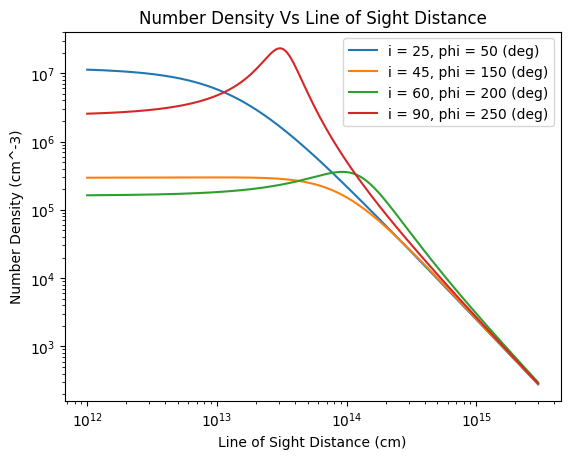

In [7]:
#Plotting the number density as a function of line of sight distance
plt.plot(s, n_e1, label = 'i = ' + str(i_deg[0]) + ', phi = ' + str(phi_deg[0]) + ' (deg)')
plt.plot(s, n_e2, label = 'i = ' + str(i_deg[1]) + ', phi = ' + str(phi_deg[1]) + ' (deg)')
plt.plot(s, n_e3, label = 'i = ' + str(i_deg[2]) + ', phi = ' + str(phi_deg[2]) + ' (deg)')
plt.plot(s, n_e4, label = 'i = ' + str(i_deg[3]) + ', phi = ' + str(phi_deg[3]) + ' (deg)')
plt.title('Number Density Vs Line of Sight Distance')
plt.xlabel('Line of Sight Distance (cm)')
plt.ylabel('Number Density (cm^-3)')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Number Density Vs Line of Sight Distance GIF

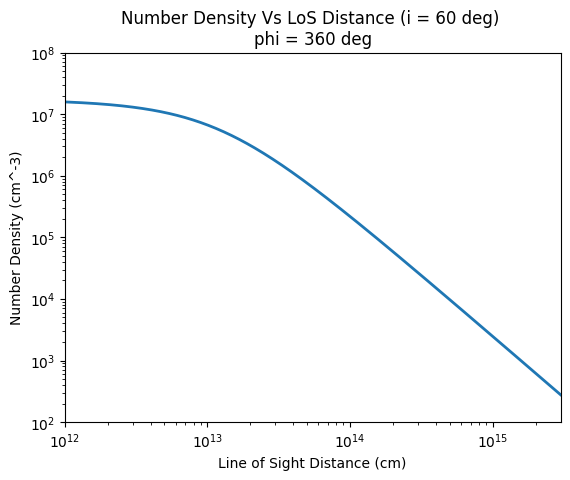

In [8]:
phi_deg_array = np.linspace(0, 360, 180)   #Orbital phases in deg
phi_array = np.deg2rad(phi_deg_array)      #Orbital phases in rad
i_gif = np.deg2rad(60)                     #Inclination in rad

#Setting up the figure
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e12, (20000 * con.au).value)
ax.set_ylim(1e2, 1e8) 
ax.set_xlabel('Line of Sight Distance (cm)')
ax.set_ylabel('Number Density (cm^-3)')
title = ax.set_title('')

#Frame update function
def update(frame):
    phi = phi_array[frame]
    n_e = num_density(phi, i_gif, a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                      v_0_kms=10, v_inf_kms=1000, s=s, e=0.87, omega=om, Omega=Om, beta=0.5)
    line.set_data(s, n_e)
    title.set_text('Number Density Vs LoS Distance (i = 60 deg) \nphi = ' + str(int(phi_deg_array[frame])) + ' deg')
    return line, title

#Animating
ani = animation.FuncAnimation(fig, update, frames=len(phi_array), blit=False, interval=100)
#Saving GIF
ani.save("num_density_evolution.gif", writer="pillow", fps=10)
plt.show()

# Interactive Number Density Vs Line of Sight Distance Widget

In [9]:
#Orbital phase slider
phi_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=360,
    step=1,
    description='Phi (deg)',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

#Interactive plotting function
def plot_n_e(phi_deg):
    phi_rad = np.deg2rad(phi_deg)
    n_e_plot = num_density(phi_rad, i_gif, a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                           v_0_kms=10, v_inf_kms=1000, s=s, e=0.87, omega=om, Omega=Om, beta=0.5) #Number density
    
    plt.plot(s, n_e_plot)
    plt.title('Number Density Vs Line of Sight Distance\nphi = ' + str(int(phi_deg))+ ' deg')
    plt.xlabel('Line of Sight Distance (cm)')
    plt.ylabel('Number Density (cm^-3)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e12, (20000 * con.au).value)
    plt.show()

#Linking slider to plot function
widgets.interact(plot_n_e, phi_deg=phi_slider)

interactive(children=(IntSlider(value=0, description='Phi (deg)', layout=Layout(width='80%'), max=360), Output…

<function __main__.plot_n_e(phi_deg)>

# Eclipsing Cases of Orbital Phases

For the orbital phase $\phi = 231^\circ$, the line of sight intersects the stellar radius at an edge-on inclination ($i = 90^\circ$), resulting in an eclipsed signal.

C:\Users\david\AppData\Local\Temp\ipykernel_9060\1711043343.py:34: RuntimeWarning: invalid value encountered in sqrt
  v_r_s = v_0 + (v_inf-v_0)*(1-R_star/np.sqrt(r_s_sqrd))**beta                                                         #Calculates the velocity of the wind


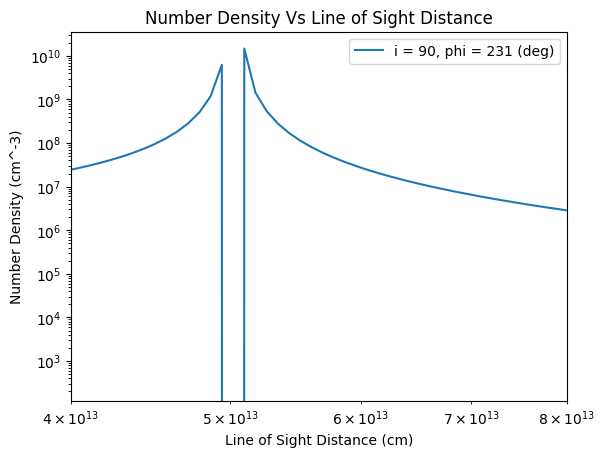

In [10]:
i_deg_ec_sig = 90                       #Eclipsing inclination in deg
i_ec_sig = np.deg2rad(i_deg_ec_sig)     #Eclipsing inclination in rad
phi_deg_ec_sig = 231                    #Eclipsing orbital phase in deg
phi_ec_sig = np.deg2rad(phi_deg_ec_sig) #Eclipsing orbital phase in rad

n_e_ec_sig = num_density(phi_ec_sig, i_ec_sig, a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                   v_0_kms=10, v_inf_kms=1000, s=s, e=0.87, omega=om, Omega=Om, beta=0.5)        #Number density

#Plotting
plt.plot(s, n_e_ec_sig, label = 'i = ' + str(i_deg_ec_sig) + ', phi = ' + str(phi_deg_ec_sig) + ' (deg)')
plt.title('Number Density Vs Line of Sight Distance')
plt.xlabel('Line of Sight Distance (cm)')
plt.ylabel('Number Density (cm^-3)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(4e13, 8e13)
plt.legend()

C:\Users\david\AppData\Local\Temp\ipykernel_9060\1711043343.py:34: RuntimeWarning: invalid value encountered in sqrt
  v_r_s = v_0 + (v_inf-v_0)*(1-R_star/np.sqrt(r_s_sqrd))**beta                                                         #Calculates the velocity of the wind


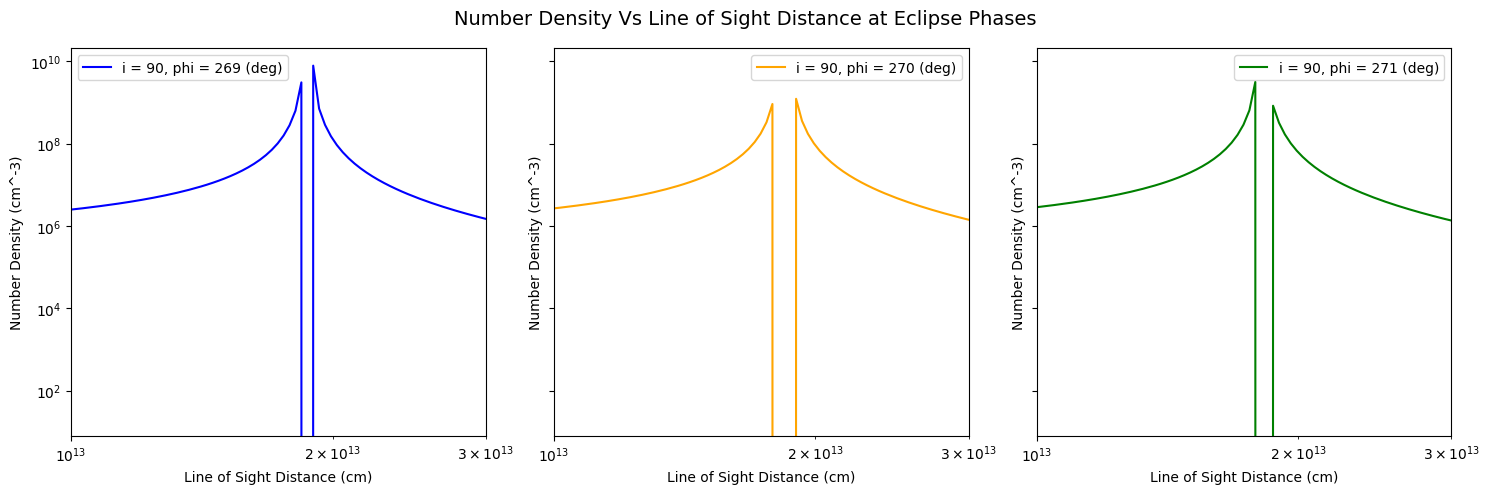

In [11]:
i_deg_eclipse = 90                                          #Eclipsing inclination
i_eclipse = np.deg2rad(i_deg_eclipse)                       #Eclipsing inclination in rad
phi_deg_eclipse = [269, 270, 271]                           #Eclipsing orbital phases
phi_eclipse = np.deg2rad(phi_deg_eclipse)                   #Eclipsing orbital phases in rad
colors = ['blue', 'orange', 'green']                        #Color array
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True) #Sub-plots

#Plotting loop
for idx, ax in enumerate(axs):
    n_e_eclipse = num_density(phi_eclipse[idx], i_eclipse, a_Rsun=1091, R_star_sol=6, Mdot_Msun_per_yr=1e-8,
                              v_0_kms=10, v_inf_kms=1350, s=s, e=0.87, omega=np.deg2rad(45), Omega=np.deg2rad(135), beta=0.5)
    
    ax.plot(s, n_e_eclipse, color=colors[idx], label = 'i = ' + str(i_deg_eclipse) + ', phi = ' + str(phi_deg_eclipse[idx]) + ' (deg)')
    ax.set_xlabel('Line of Sight Distance (cm)')
    ax.set_ylabel('Number Density (cm^-3)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e13, 3e13)
    ax.legend()
    
plt.suptitle('Number Density Vs Line of Sight Distance at Eclipse Phases', fontsize=14)
plt.tight_layout()

# Dispersion Measure

In [12]:
#Calculating the DM
phi = np.linspace(0, 2*np.pi, 512, endpoint=False)                                  #Orbital phase array in rad (redundancy removed)
DM1 = dm_beta_wind(phi, i[0], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                  v_0_kms=10, v_inf_kms=1000, e=0.87, omega=om, Omega=Om, beta=0.5) #Dispersion measure
DM2 = dm_beta_wind(phi, i[1], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                  v_0_kms=10, v_inf_kms=1000, e=0.87, omega=om, Omega=Om, beta=0.5)
DM3 = dm_beta_wind(phi, i[2], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                  v_0_kms=10, v_inf_kms=1000, e=0.87, omega=om, Omega=Om, beta=0.5)

In [13]:
#print(phi)
#print(DM)

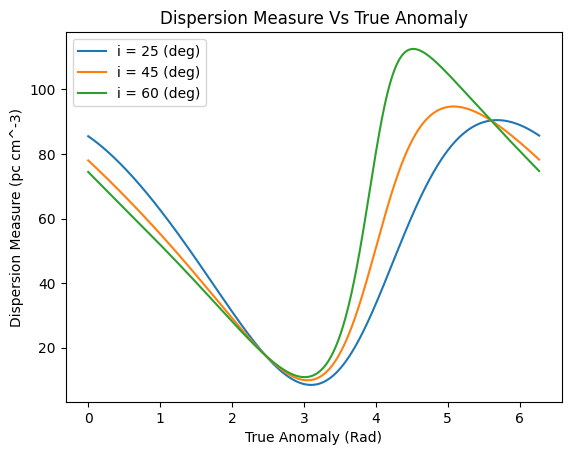

In [14]:
#Plotting the DM as a function of the orbital phase
plt.plot(phi, DM1, label = 'i = ' + str(i_deg[0]) + ' (deg)')
plt.plot(phi, DM2, label = 'i = ' + str(i_deg[1]) + ' (deg)')
plt.plot(phi, DM3, label = 'i = ' + str(i_deg[2]) + ' (deg)')
plt.title('Dispersion Measure Vs True Anomaly')
plt.xlabel('True Anomaly (Rad)')
plt.ylabel('Dispersion Measure (pc cm^-3)')
plt.legend()

# Free-free Absorption

In [15]:
#Calculating the optical depth
phi = np.linspace(0, 2*np.pi, 512, endpoint=False)                                                   #Orbital phase array in rad (redundancy removed)
nu = [1.5, 1.75, 2]                                                                                  #Signal frequency in GHz
tau1 = ffa(phi, i[0], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                  v_0_kms=10, v_inf_kms=1000, e=0.87, omega=om, Omega=Om, beta=0.5, nu=nu[0], T=1e4) #Optical depth
tau2 = ffa(phi, i[1], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                  v_0_kms=10, v_inf_kms=1000, e=0.87, omega=om, Omega=Om, beta=0.5, nu=nu[1], T=1e4)
tau3 = ffa(phi, i[2], a_Rsun=1345, R_star_sol=9, Mdot_Msun_per_yr=1e-7,
                  v_0_kms=10, v_inf_kms=1000, e=0.87, omega=om, Omega=Om, beta=0.5, nu=nu[2], T=1e4)

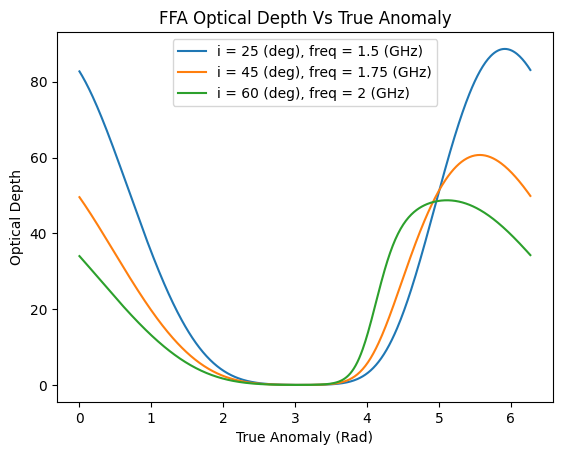

In [16]:
#Plotting the optical depth as a function of the orbital phase
plt.plot(phi, tau1, label = 'i = ' + str(i_deg[0]) + ' (deg), freq = ' + str(nu[0]) + ' (GHz)')
plt.plot(phi, tau2, label = 'i = ' + str(i_deg[1]) + ' (deg), freq = ' + str(nu[1]) + ' (GHz)')
plt.plot(phi, tau3, label = 'i = ' + str(i_deg[2]) + ' (deg), freq = ' + str(nu[2]) + ' (GHz)')
plt.title('FFA Optical Depth Vs True Anomaly')
plt.xlabel('True Anomaly (Rad)')
plt.ylabel('Optical Depth')
plt.legend()